# Reacher - robot arm controller.

---

Created by Jesper Højmark Esbensen, 2018-10-30.

This note book will create and train an agent to control the 'robot arm' in the Unity Machine Learning environment Reacher. The solution is based on the general deep reenforcement learning agent supplied in the cource [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893).

<img src="Reacher20.png",width=750>

The environment consists of a 'robot arm' with a 'hand' that the agent must control to touch a goal. The goal is a sphere that is rotating around the robot with different speed and direction of each episode. An episode is 1000 steps in the environment.

A variant of the environment contains the same setup but with 20 robot arms.

These and a number of other environments from Unity can be found here. [Unity environments](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Learning-Environment-Examples.md#reacher).


### 1. Installation instructions

Installation instructions can be found in the readme.md file in the github repository: https://github.com/JesperEsbensen/drlnd-continuous-contro


### 2. This solution

The solution in this note book is heavely inspired by the solution to the bi-pedal environment given in the repository: https://github.com/udacity/deep-reinforcement-learning/tree/master/ddpg-bipedal

It has been modified to handle the reacher environment and the rebuild to handle multiple executions of the excercise.

#### Algorithm

The implementation is based on the Deep Deterministic Policy Gradient algorithme described in the paper:

[Continuous control with deep reinforcement learning](https://arxiv.org/abs/1509.02971)

The algorithm has shown to performe in different simulated environments. It is a continuous algorithm and therefore suitable for the reaher envrionment. 
The algorithm is based on the Deterministic Policy Gradient (DPG) method that is created around an actor-critic setup. To make the algorithm stable it uses a "replay buffer" and "target/local network". To add exploration it introduces noise to calculated actions.


#### An experiment



### 3. The code 

#### Imports
This cell handles the imports of the Unity environment, pyTorch and python modules.


In [1]:
# Import Unity for the environment
from unityagents import UnityEnvironment

# Import for file handling.
import os

# Import numpy for the math
import numpy as np

# Import torch for the AI
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# A little extra than standard python.
from collections import namedtuple, deque
import random
import copy

# Time for timing
import time


#### Environment
This cell defines a class for handling a Unity environment. It helps handle the start, close down and the extraction of values.


In [2]:
class Environment ():
    
    # Encapsulates the environment and enables the use of 'with' to handle open/close.
    
    def __init__(self, envFile):
        """Initialize parameters for environment.
        Params
        ======
            envFile (string): Path to envrionment executable
        """
        self.filename = envFile
        self.env = UnityEnvironment(file_name=envFile)
            
        # get the default brain
        self.brain_name = self.env.brain_names[0]
        self.brain = self.env.brains[self.brain_name]

        # reset the environment
        self.env_info = self.env.reset(train_mode=True)[self.brain_name]
        
        print ('Created unity enviroment from ', envFile)
        self.dump_key_attributes()
        
    def __enter__(self):
        return self
            
    def state_size(self):
        return self.env_info.vector_observations.shape[1]
        
    def action_size(self):
        return self.brain.vector_action_space_size

    def agent_size(self):
        return len(self.env_info.agents)
    
    def reset(self, train_mode=True):
        self.env_info = self.env.reset(train_mode=True)[self.brain_name]
        return self.env_info.vector_observations, self.env_info.rewards, self.env_info.local_done

    def step(self, actions):
        self.env_info = self.env.step(actions)[self.brain_name]
        return self.env_info.vector_observations, self.env_info.rewards, self.env_info.local_done

    def states(self, train_mode=True):
        return self.env.reset(train_mode=True)[self.brain_name]
    
    def dump_key_attributes (self):
        print('Environment     :', self.filename)
        print('Number of agents:', self.agent_size())
        print('State size      :', self.state_size())
        print('Action size     :', self.action_size())
        
    def end():
        self.env.close()

    def __exit__(self, exc_type, exc_value, traceback):
        self.env.close()


#### Utility
An utility function for initializing a layer in the network.

In [3]:
def hidden_init(layer):
    fan_in = layer.weight.data.size()[0]
    lim = 1. / np.sqrt(fan_in)
    return -lim, lim

#### Actor network
The actor network to determin the actions to take from the given state. 
The network is build up from experiments. The structure is:

- fully connecte layer -> batch nomalization -> relu ->  fully connecte layer -> relu -> tanh

where the first fully connected layer takes a vector with the size of the states. An the final tanh layer delivers a vector of actions to take in the range ]-1,1[


In [4]:
class Actor(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, state_size, action_size, seed, fc1_units=132, fc2_units=132):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fc1_units (int): Number of nodes in first hidden layer
            fc2_units (int): Number of nodes in second hidden layer
        """
        super(Actor, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.bn1 = nn.BatchNorm1d(num_features=fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.bn2 = nn.BatchNorm1d(num_features=fc2_units)
        self.fc3 = nn.Linear(fc2_units, action_size)
        self.reset_parameters()

    def reset_parameters(self):
        f,t = hidden_init(self.fc1)
        self.fc1.weight.data.uniform_(f,t)
        f,t = hidden_init(self.fc2)
        self.fc2.weight.data.uniform_(f,t)
        self.fc3.weight.data.uniform_(-3e-3,3e-3)

    def forward(self, state):
        
        """Build an actor (policy) network that maps states -> actions."""
        x = self.fc1(state)
        x = self.bn1(x)
        x = F.relu(x)        
        x = self.fc2(x)
        x = self.bn2(x)
        x = F.relu(x)        
        x = self.fc3(x)
        x = torch.tanh(x)

        return x

#### Global settings - hyper parameters

In [5]:
BUFFER_SIZE = int(1e6)  # replay buffer size
BATCH_SIZE = 256        # minibatch size
GAMMA = 0.99            # discount factor
TAU = 1e-3              # for soft update of target parameters
LR_ACTOR = 1e-3         # learning rate of the actor 
LR_CRITIC = 1e-3        # learning rate of the critic
WEIGHT_DECAY = 0.00     # L2 weight decay
NOISE_SIGMA = 0.20
NOISE_THETA = 0.15 
NOISE_DECAY = 0.99997

#### Hardware

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print (device)

cuda:0


#### Critic network
The critic network to estimate the value of taking an action - the reward. 
The network is build up from experiments. The structure is:

- (states + actions) -> fully connected layer -> batch nomalization -> relu -> fully connected layer -> relu -> fully connected layer
                                           
The states are passed through a first layer then concatenated with the actions and passed through another layer to end with one value.

In [7]:
class Critic(nn.Module):
    """Critic (Value) Model."""

    def __init__(self, state_size, action_size, seed, fc1_units=148, fc2_units=148):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fcs1_units (int): Number of nodes in the first hidden layer
            fc2_units (int): Number of nodes in the second hidden layer
        """
        super(Critic, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.bn1 = nn.BatchNorm1d(fc1_units)
        self.fc2 = nn.Linear(fc1_units + action_size, fc2_units)
        self.bn2 = nn.BatchNorm1d(fc2_units)
        self.fc3 = nn.Linear(fc2_units, 1)

        self.reset_parameters()

    def reset_parameters(self):
        f,t = hidden_init(self.fc1)
        self.fc1.weight.data.uniform_(f,t)
        f,t = hidden_init(self.fc2)
        self.fc2.weight.data.uniform_(f,t)
        self.fc3.weight.data.uniform_(-3e-3,3e-3)

    def forward(self, state, action):
        """Build a critic (value) network that maps (state, action) pairs -> Q-values."""
        x = self.fc1(state)
        x = self.bn1(x)
        x = F.relu(x)
        x = torch.cat((x, action), dim=1)
        x = self.fc2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.fc3(x)
        
        return x

#### The Agent

The agent handles the networks: actor, critic and thier target and local versions. It handles the noice generator, the replay buffer, the act and learn steps.
Note that a decay rate of the noice has been build in. This way the noise is higher in the beginning and becomes lower with the number of steps taken.

In [8]:
class Agent():
    """Interacts with and learns from the environment."""
    
    def __init__(self, environment, random_seed, reward_level=-1.0):
        """Initialize an Agent object.
        
        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            random_seed (int): random seed
        """
        self.env = environment
        
        self.state_size = self.env.state_size()
        self.action_size = self.env.action_size()
        self.agent_size = self.env.agent_size()
        self.seed = random.seed(random_seed)

        # Actor Network (w/ Target Network)
        fc1 = self.state_size * 4
        fc2 = fc1
        self.actor_local = Actor(self.state_size, self.action_size, random_seed, fc1_units=fc1, fc2_units=fc2).to(device)
        self.actor_target = Actor(self.state_size, self.action_size, random_seed, fc1_units=fc1, fc2_units=fc2).to(device)
        self.actor_optimizer = optim.Adam(self.actor_local.parameters(), lr=LR_ACTOR)

        # Critic Network (w/ Target Network)
        fc1 = (self.state_size + self.action_size) * 4
        fc2 = fc1
        self.critic_local = Critic(self.state_size, self.action_size, random_seed, fc1_units=fc1, fc2_units=fc2).to(device)
        self.critic_target = Critic(self.state_size, self.action_size, random_seed, fc1_units=fc1, fc2_units=fc2).to(device)
        self.critic_optimizer = optim.Adam(self.critic_local.parameters(), lr=LR_CRITIC, weight_decay=WEIGHT_DECAY)

        # Noice processes
        self.noise = []
        self.noise_decay = NOISE_DECAY
        for i in range(self.agent_size):
            self.noise.append(OUNoise(self.action_size, random_seed, theta=NOISE_THETA , sigma=NOISE_SIGMA))
        self.noise_rate = np.ones(self.agent_size)
        self.noice_counter = 0
        self.step_counter = 0

        # Replay memory
        self.memory = ReplayBuffer(self.action_size, BUFFER_SIZE, BATCH_SIZE, random_seed, reward_level)
        
        print ('Created agent: states = ', self.state_size, ' actions = ', self.action_size, ' reward level = ', reward_level)

    
    def step(self, states, actions, rewards, next_states, dones):
        """Save experience in replay memory, and use random sample from buffer to learn."""
        self.step_counter += 1
        
        # Save experience / reward
        for state, action, reward, next_state, done in zip(states, actions, rewards, next_states, dones):
            self.memory.add(state, action, reward, next_state, done)

        # Learn, if enough samples are available in memory
        if len(self.memory) > BATCH_SIZE and self.step_counter % 20 == 0:
            for _ in range(10):
                experiences = self.memory.sample()
                self.learn(experiences, GAMMA)

    def act(self, state, add_noise=True):
        """Returns actions for given state as per current policy."""
        state = torch.from_numpy(state).float().to(device)
        self.actor_local.eval()
        with torch.no_grad():
            action = self.actor_local(state).cpu().data.numpy()
            
        self.actor_local.train()
        
        if add_noise:
            self.noise_decay = self.noise_decay * NOISE_DECAY
            self.noice_counter += 1
            
            for i in range(self.agent_size):
                noise = self.noise[i].sample()
                
                if self.noice_counter % 500 == 0:
                    self.noise_rate[i] = np.linalg.norm(noise  * self.noise_decay)/float(np.linalg.norm(action[i]))
                    
                action[i] += noise * self.noise_decay
            
        return action

    def reset(self):
        for noise in self.noise:
            noise.reset()

    def learn(self, experiences, gamma):
        """Update policy and value parameters using given batch of experience tuples.
        Q_targets = r + γ * critic_target(next_state, actor_target(next_state))
        where:
            actor_target(state) -> action
            critic_target(state, action) -> Q-value

        Params
        ======
            experiences (Tuple[torch.Tensor]): tuple of (s, a, r, s', done) tuples 
            gamma (float): discount factor
        """
        
        states, actions, rewards, next_states, dones = experiences

        # ---------------------------- update critic ---------------------------- #
        # Get predicted next-state actions and Q values from target models
        actions_next = self.actor_target(next_states)
        Q_targets_next = self.critic_target(next_states, actions_next)
        # Compute Q targets for current states (y_i)
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))
        # Compute critic loss
        Q_expected = self.critic_local(states, actions)
        critic_loss = F.mse_loss(Q_expected, Q_targets)
        # Minimize the loss
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()

            
        # ---------------------------- update actor ---------------------------- #
        # Compute actor loss
        actions_pred = self.actor_local(states)
        actor_loss = -self.critic_local(states, actions_pred).mean()
        # Minimize the loss
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()
            
        # ----------------------- update target networks ----------------------- #
        self.soft_update(self.critic_local, self.critic_target, TAU)
        self.soft_update(self.actor_local, self.actor_target, TAU)     
        

    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target

        Params
        ======
            local_model: PyTorch model (weights will be copied from)
            target_model: PyTorch model (weights will be copied to)
            tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)
            
    def environment(self):
        return self.env
    

#### Noise

Noise is introduced to the actions generated to enabled the network to explore "alternative" actions.
Note that the Ornenstein-Uhlenbeck is modified to give negaive random numbers as well.

In [9]:
class OUNoise:
    """Ornstein-Uhlenbeck process."""

    def __init__(self, size, seed, mu=0., theta=0.15, sigma=0.2):
        """Initialize parameters and noise process."""
        self.mu = mu * np.ones(size)
        self.theta = theta
        self.sigma = sigma
        self.seed = random.seed(seed)
        self.reset()

    def reset(self):
        """Reset the internal state (= noise) to mean (mu)."""
        self.state = copy.copy(self.mu)

    def sample(self):
        """Update internal state and return it as a noise sample."""
        x = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.array([(random.random() - 0.5)*2 for i in range(len(x))])
        #dx = self.theta * (self.mu - x) + self.sigma * np.array([random.random() for i in range(len(x))])
        self.state = x + dx
        
        return self.state


#### Replay buffer

The replay buffer is a buffer where tuples of stats, action, rewards are stored. They can in random order be sampled and used  in the learning process. By selecting the steps the correlation between steps is broken.



In [10]:
class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed, reward_level=-1.0):
        """Initialize a ReplayBuffer object.
        Params
        ======
            action_size (int): action size
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
            seed (): For random generation and initilization of the noise generator.
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)  # Internal memory (deque)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
        self.reward_level = reward_level
        self.add_counter = 0
        self.rf = 0
    
    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
    
        # Every thousand steps we calculate the reward fraction.
        self.add_counter += 1
        if self.add_counter % 1000 == 0:
            if len (self.memory) > 0:
                self.rf = self.rewards () / len (self.memory)
        
        # We add all actions that gave a success, and only some that dident.
        if reward > 0.0001:
            self.memory.append(e)
        else:
            if self.rf > self.reward_level:
                self.memory.append(e)        
        
    def rewards (self):
        rewardCounter = 0
        for entry in self.memory:
            if entry.reward > 0:
                rewardCounter += 1
        return rewardCounter
    
    def reward_fraction(self):
        return self.rf

    
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).float().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)
        
        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)
    
    

#### Main loop

The main loop drives the process of having the agent act in the environment.
Loop episodes and timesteps to drive the environment, agent and learning.

When the goal is reached the process will continue for another 25% episodes to see what happens. A loop will start from a set of actor/critics files if they exist. A set of actor and critics network is stored every time a better result is reached and a separate set when the goal is reached.

In addition to the average score this the main loop will display:
* reward fraction - number of actions with success of all of the stored actions (for the experiment)
* Noice level - vector length of noise added compared to action vector.
* Time - loop time of episode.

For every episode if at better result has been achieved the parameters are stored. When the goal is reached the parameters are also stored - and kept.

In [11]:
def ddpg(name, agent, n_episodes=200, max_t=1000, print_every=100, goal=30):
    
    checkpointfile = name + '-best_actor.pth'
    if os.path.isfile(checkpointfile):
        print('\nLoading checkpoints - and continue learning:', checkpointfile)
        agent.actor_local.load_state_dict(torch.load(name + '-best_actor.pth'))
        agent.actor_target.load_state_dict(torch.load(name + '-best_actor.pth'))
        agent.critic_local.load_state_dict(torch.load(name + '-best_critic.pth'))
        agent.critic_target.load_state_dict(torch.load(name + '-best_critic.pth'))
    else:
        print('\nRestart learning - no checkpoint file found:', checkpointfile)
        
    env = agent.environment()
    
    scores_deque = deque(maxlen=print_every)
    scores = []
    best_score = 0
    goal_passed = 0
    goal_passed_counter = 0
    
    # Drive episodes.
    for i_episode in range(1, n_episodes+1):
        
        start = time.time()

        states, rewards, dones = env.reset()
        score_agents = np.zeros(env.agent_size())
        
        agent.reset()

        for t in range(max_t):
            
            # Calculate best actions for this step.
            actions = agent.act(states, True)
            
            # Determin next state.
            next_states, rewards, dones = env.step(actions)  # send the action to the environment
                
            # Agent takes step and learns.
            agent.step(states, actions, rewards, next_states, dones)
                
            # Prepare next loop.
            states = next_states
            score_agents += rewards
            
            if np.any(dones):
                break 
        
        score = np.mean(score_agents)
        scores_deque.append(score)
        scores.append(score)
        
        score_average = np.mean(scores_deque)
        
        end = time.time()
        
        # Store model parameters if it is better than the last best.
        if score_average > best_score:
            best_score = score_average
            torch.save(agent.actor_local.state_dict(), name + '-best_actor.pth')
            torch.save(agent.critic_local.state_dict(), name + '-best_critic.pth')
            print('\rEpisode {}, Average Score: {:.2f}, ({:.2f}/{:.2f}), Reward fraction {:.2f}\tTime {:.2f}, Noise rate {:.3f}. Better model.'.format( \
                i_episode, np.mean(scores_deque), np.max(score_agents), np.min(score_agents), agent.memory.reward_fraction(), end - start, \
                sum(agent.noise_rate)/float(len(agent.noise_rate))))
        else:
            print('\rEpisode {}, Average Score: {:.2f}, ({:.2f}/{:.2f}), Reward fraction {:.2f}\tTime {:.2f}, Noise rate {:.3f}.'.format( \
                i_episode, np.mean(scores_deque), np.max(score_agents), np.min(score_agents), agent.memory.reward_fraction(), end - start, \
                sum(agent.noise_rate)/float(len(agent.noise_rate))), end="" )
        
        if i_episode % print_every == 0:
            print('\rEpisode {}, Average Score: {:.2f}, ({:.2f}/{:.2f}), Reward fraction {:.2f}\tTime {:.2f}, Noise rate {:.3f}.'.format( \
                i_episode, np.mean(scores_deque), np.max(score_agents), np.min(score_agents), agent.memory.reward_fraction(), end - start, \
                sum(agent.noise_rate)/float(len(agent.noise_rate))))
            
        if score_average >= goal:
            if goal_passed == 0:
                goal_passed = i_episode
                
                print('\nGoal reached in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode, score_average))
                torch.save(agent.actor_local.state_dict(), name + '-goal_actor.pth')
                torch.save(agent.critic_local.state_dict(), name + '-goal_critic.pth')
            
        if goal_passed > 0:
            goal_passed_counter = goal_passed_counter + 1
            
        if goal_passed > 0 and goal_passed_counter > goal_passed * 0.2: # Run addtional 20% episodes to see what happens.
            break
            

            
    return scores


#### Plotting

Below you find two functions for plotting the scores collected. For one timeseries and for comparing two timeseries.

In [12]:
import matplotlib.pyplot as plt

def plotScores (scores):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    plt.plot(np.arange(1, len(scores)+1), scores)
    plt.ylabel('Score')
    plt.xlabel('Episode #')
    plt.show()

In [13]:
import matplotlib.pyplot as plt

def plotCompareScores (score1, score2):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    plt.plot(np.arange(1, len(score1)+1), score1)
    plt.plot(np.arange(1, len(score2)+1), score2)
    plt.ylabel('Score')
    plt.xlabel('Episode #')
    plt.show()

### 4. Execution

#### Test the reward level experiment
The two networks are executet and compared to see what effect the reward level experiment has.


In [14]:
with Environment (envFile='.\Reacher_Windows_x86_64_20Agents\Reacher.exe') as env:
    s1 = ddpg ( '20Agents', Agent(env, random_seed=2, reward_level=-1.0), goal=30, n_episodes=200 )

with Environment (envFile='.\Reacher_Windows_x86_64_20Agents\Reacher.exe') as env:
    s2 = ddpg ( '20AgentsBias', Agent(env, random_seed=2, reward_level=0.25), goal=30, n_episodes=200 )

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Created unity enviroment from  .\Reacher_Windows_x86_64_20Agents\Reacher.exe
Environment     : .\Reacher_Windows_x86_64_20Agents\Reacher.exe
Number of agents: 20
State size      : 33
Action size     : 4
Created agent: states =  33  actions =  4  reward level =  -1.0

Restart learning - no checkpoint file found: 20Agents-best_actor.pth
Episode 1, Average Score: 0.69, (1.60/0.15), Reward fraction 0.02	Time 11.79, Noise rate 0.318. Better model.
Episode 2, Average Score: 0.82, (1.84/0.00), Reward fraction 0.02	Time 11.37, Noise rate 0.314. Better model.
Episode 3, Average Score: 0.88, (1.97/0.25), Reward fraction 0.03	Time 11.31, Noise rate 0.242. Better model.
Episode 4, Average Score: 0.88, (2.19/0.10), Reward fraction 0.03	Time 11.51, Noise rate 0.216. Better model.
Episode 5, Average Score: 0.91, (2.02/0.13), Reward fraction 0.03	Time 11.42, Noise rate 0.206. Better model.
Episode 7, Average Score: 0.94, (3.08/0.36), Reward fraction 0.03	Time 11.69, Noise rate 0.182. Better model.
Epi

Episode 72, Average Score: 26.07, (39.46/17.27), Reward fraction 0.89	Time 18.62, Noise rate 0.082. Better model.
Episode 73, Average Score: 26.21, (39.52/24.02), Reward fraction 0.89	Time 18.61, Noise rate 0.065. Better model.
Episode 74, Average Score: 26.33, (39.62/15.67), Reward fraction 0.90	Time 18.71, Noise rate 0.066. Better model.
Episode 75, Average Score: 26.49, (39.63/29.12), Reward fraction 0.90	Time 19.35, Noise rate 0.061. Better model.
Episode 76, Average Score: 26.62, (39.59/22.81), Reward fraction 0.90	Time 19.10, Noise rate 0.065. Better model.
Episode 77, Average Score: 26.71, (39.57/12.26), Reward fraction 0.91	Time 18.74, Noise rate 0.058. Better model.
Episode 78, Average Score: 26.83, (39.60/26.90), Reward fraction 0.91	Time 18.62, Noise rate 0.052. Better model.
Episode 79, Average Score: 26.93, (39.55/15.04), Reward fraction 0.91	Time 18.67, Noise rate 0.050. Better model.
Episode 80, Average Score: 27.05, (39.53/16.87), Reward fraction 0.91	Time 18.56, Noise 

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Created unity enviroment from  .\Reacher_Windows_x86_64_20Agents\Reacher.exe
Environment     : .\Reacher_Windows_x86_64_20Agents\Reacher.exe
Number of agents: 20
State size      : 33
Action size     : 4
Created agent: states =  33  actions =  4  reward level =  0.25

Restart learning - no checkpoint file found: 20AgentsBias-best_actor.pth
Episode 1, Average Score: 0.76, (1.66/0.04), Reward fraction 0.18	Time 10.59, Noise rate 0.244. Better model.
Episode 3, Average Score: 0.88, (2.88/0.28), Reward fraction 0.24	Time 11.28, Noise rate 0.285. Better model.
Episode 4, Average Score: 0.90, (1.99/0.18), Reward fraction 0.23	Time 11.52, Noise rate 0.250. Better model.
Episode 9, Average Score: 0.91, (2.42/0.19), Reward fraction 0.24	Time 11.00, Noise rate 0.189. Better model.
Episode 10, Average Score: 0.95, (2.06/0.38), Reward fraction 0.25	Time 10.98, Noise rate 0.197. Better model.
Episode 11, Average Score: 1.00, (2.83/0.21), Reward fraction 0.25	Time 11.05, Noise rate 0.207. Better mode

Episode 76, Average Score: 23.96, (39.55/22.46), Reward fraction 0.86	Time 18.58, Noise rate 0.058. Better model.
Episode 77, Average Score: 24.05, (39.47/1.69), Reward fraction 0.87	Time 18.61, Noise rate 0.050. Better model.
Episode 78, Average Score: 24.14, (39.50/17.34), Reward fraction 0.87	Time 18.66, Noise rate 0.047. Better model.
Episode 79, Average Score: 24.22, (39.48/12.01), Reward fraction 0.87	Time 18.59, Noise rate 0.059. Better model.
Episode 80, Average Score: 24.34, (39.30/15.48), Reward fraction 0.88	Time 18.86, Noise rate 0.050. Better model.
Episode 81, Average Score: 24.47, (39.53/23.69), Reward fraction 0.88	Time 18.62, Noise rate 0.051. Better model.
Episode 82, Average Score: 24.54, (38.74/4.51), Reward fraction 0.89	Time 19.29, Noise rate 0.044. Better model.
Episode 83, Average Score: 24.58, (38.89/0.60), Reward fraction 0.88	Time 18.77, Noise rate 0.041. Better model.
Episode 84, Average Score: 24.63, (37.20/1.30), Reward fraction 0.88	Time 18.54, Noise rate

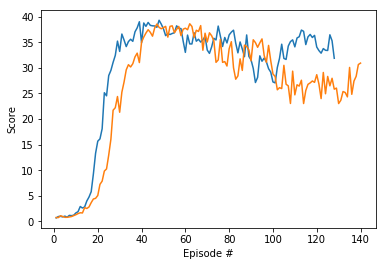

In [15]:
plotCompareScores (s1, s2)

The goal was reached in 107 episodes for the non modified version for the network, and in 117 for the version where a minimum for successful actions where required. The modified version will run faster until the 25% reward level is reached, but it does not seem to improve the performance in a significant way.



#### Test test same DDPG on the Single agent version of the reacher environement.

In [16]:
# Run for the one agent environment 
with Environment (envFile='.\Reacher_Windows_x86_64\Reacher.exe') as env:
    singleReacher = ddpg ( 'SingleAgent', Agent(env, random_seed=2), goal=30, n_episodes=500 )

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Created unity enviroment from  .\Reacher_Windows_x86_64\Reacher.exe
Environment     : .\Reacher_Windows_x86_64\Reacher.exe
Number of agents: 1
State size      : 33
Action size     : 4
Created agent: states =  33  actions =  4  reward level =  -1.0

Restart learning - no checkpoint file found: SingleAgent-best_actor.pth
Episode 1, Average Score: 1.21, (1.21/1.21), Reward fraction 0.03	Time 7.42, Noise rate 0.260. Better model.
Episode 28, Average Score: 1.24, (3.62/3.62), Reward fraction 0.03	Time 9.46, Noise rate 0.064. Better model.
Episode 30, Average Score: 1.28, (2.61/2.61), Reward fraction 0.04	Time 9.41, Noise rate 0.086. Better model.
Episode 33, Average Score: 1.34, (3.34/3.34), Reward fraction 0.04	Time 9.45, Noise rate 0.082. Better model.
Episode 34, Average Score: 1.37, (2.37/2.37), Reward fraction 0.04	Time 9.55, Noise rate 0.089. Better model.
Episode 35, Average Score: 1.47, (4.90/4.90), Reward fraction 0.04	Time 9.48, Noise rate 0.090. Better model.
Episode 36, Average 

Episode 107, Average Score: 7.16, (23.43/23.43), Reward fraction 0.18	Time 9.61, Noise rate 0.020. Better model.
Episode 108, Average Score: 7.31, (16.08/16.08), Reward fraction 0.18	Time 9.72, Noise rate 0.010. Better model.
Episode 109, Average Score: 7.53, (22.63/22.63), Reward fraction 0.18	Time 9.77, Noise rate 0.015. Better model.
Episode 110, Average Score: 7.83, (30.60/30.60), Reward fraction 0.19	Time 9.67, Noise rate 0.007. Better model.
Episode 111, Average Score: 7.93, (12.53/12.53), Reward fraction 0.19	Time 9.75, Noise rate 0.012. Better model.
Episode 112, Average Score: 8.05, (12.84/12.84), Reward fraction 0.19	Time 9.72, Noise rate 0.007. Better model.
Episode 113, Average Score: 8.15, (10.48/10.48), Reward fraction 0.19	Time 9.80, Noise rate 0.009. Better model.
Episode 114, Average Score: 8.33, (20.18/20.18), Reward fraction 0.19	Time 9.75, Noise rate 0.013. Better model.
Episode 115, Average Score: 8.63, (30.57/30.57), Reward fraction 0.20	Time 9.75, Noise rate 0.00

Episode 184, Average Score: 21.86, (35.84/35.84), Reward fraction 0.36	Time 10.14, Noise rate 0.001. Better model.
Episode 185, Average Score: 22.15, (38.11/38.11), Reward fraction 0.36	Time 10.15, Noise rate 0.004. Better model.
Episode 186, Average Score: 22.36, (31.04/31.04), Reward fraction 0.37	Time 10.05, Noise rate 0.001. Better model.
Episode 187, Average Score: 22.68, (37.33/37.33), Reward fraction 0.37	Time 10.14, Noise rate 0.000. Better model.
Episode 188, Average Score: 22.93, (33.24/33.24), Reward fraction 0.37	Time 10.14, Noise rate 0.001. Better model.
Episode 189, Average Score: 22.96, (20.00/20.00), Reward fraction 0.37	Time 10.07, Noise rate 0.002. Better model.
Episode 190, Average Score: 23.22, (38.15/38.15), Reward fraction 0.38	Time 10.23, Noise rate 0.005. Better model.
Episode 191, Average Score: 23.33, (32.68/32.68), Reward fraction 0.38	Time 10.23, Noise rate 0.004. Better model.
Episode 192, Average Score: 23.63, (39.39/39.39), Reward fraction 0.38	Time 10.0

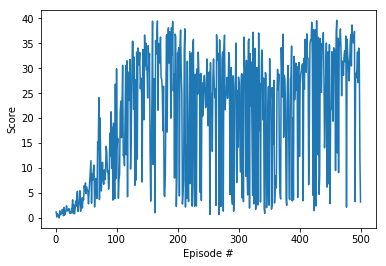

In [17]:
plotScores( singleReacher )

The single reacher environment was not solved. It seems to continouosly contain a lot of noice. But with the 1/20 number of agents it also gets less relevant observations. Whit tuning it could propably reach the goal.


#### Test test same DDPG on the Crawler agent environement.

In [18]:
# Run for the crawler agent environment 
with Environment (envFile='.\Crawler_Windows_x86_64\Crawler.exe') as env:
    crawler = ddpg ( 'Crawler', Agent(env, random_seed=2), goal=2000, n_episodes=5000 )

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: CrawlerBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 129
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 20
        Vector Action descriptions: , , , , , , , , , , , , , , , , , , , 


Created unity enviroment from  .\Crawler_Windows_x86_64\Crawler.exe
Environment     : .\Crawler_Windows_x86_64\Crawler.exe
Number of agents: 12
State size      : 129
Action size     : 20
Created agent: states =  129  actions =  20  reward level =  -1.0

Restart learning - no checkpoint file found: Crawler-best_actor.pth
Episode 1, Average Score: 4.70, (8.68/2.14), Reward fraction 0.00	Time 0.76, Noise rate 1.000. Better model.
Episode 100, Average Score: 0.44, (1.20/-0.79), Reward fraction 0.63	Time 0.04, Noise rate 0.117.
Episode 200, Average Score: 0.84, (1.31/-0.52), Reward fraction 0.69	Time 0.04, Noise rate 0.154.
Episode 300, Average Score: 0.95, (1.11/-0.50), Reward fraction 0.71	Time 0.22, Noise rate 0.150.
Episode 400, Average Score: 1.10, (3.69/-1.85), Reward fraction 0.72	Time 0.24, Noise rate 0.211.
Episode 500, Average Score: 1.76, (5.29/1.63), Reward fraction 0.73	Time 0.26, Noise rate 0.146...
Episode 600, Average Score: 3.02, (7.40/-0.63), Reward fraction 0.74	Time 0.25

Episode 741, Average Score: 6.66, (12.57/5.39), Reward fraction 0.77	Time 0.28, Noise rate 0.183. Better model.
Episode 742, Average Score: 6.69, (11.55/5.78), Reward fraction 0.77	Time 0.27, Noise rate 0.183. Better model.
Episode 743, Average Score: 6.76, (13.30/6.05), Reward fraction 0.77	Time 0.28, Noise rate 0.183. Better model.
Episode 744, Average Score: 6.77, (10.28/6.72), Reward fraction 0.77	Time 0.27, Noise rate 0.183. Better model.
Episode 745, Average Score: 6.81, (12.04/7.59), Reward fraction 0.77	Time 0.28, Noise rate 0.183. Better model.
Episode 746, Average Score: 6.85, (10.49/3.70), Reward fraction 0.77	Time 0.27, Noise rate 0.183. Better model.
Episode 747, Average Score: 6.88, (11.61/2.73), Reward fraction 0.77	Time 0.27, Noise rate 0.183. Better model.
Episode 755, Average Score: 6.89, (10.90/6.49), Reward fraction 0.77	Time 0.27, Noise rate 0.183. Better model.
Episode 756, Average Score: 6.89, (9.35/6.08), Reward fraction 0.77	Time 0.25, Noise rate 0.183. Better 

Episode 866, Average Score: 8.66, (14.99/5.27), Reward fraction 0.79	Time 0.27, Noise rate 0.166. Better model.
Episode 867, Average Score: 8.71, (11.70/7.93), Reward fraction 0.79	Time 0.27, Noise rate 0.166. Better model.
Episode 868, Average Score: 8.76, (12.02/5.56), Reward fraction 0.79	Time 0.27, Noise rate 0.166. Better model.
Episode 869, Average Score: 8.81, (10.72/6.02), Reward fraction 0.79	Time 0.28, Noise rate 0.166. Better model.
Episode 870, Average Score: 8.87, (14.03/9.58), Reward fraction 0.79	Time 0.28, Noise rate 0.166. Better model.
Episode 871, Average Score: 8.92, (15.01/9.33), Reward fraction 0.79	Time 0.30, Noise rate 0.166. Better model.
Episode 872, Average Score: 8.96, (14.26/9.20), Reward fraction 0.79	Time 0.27, Noise rate 0.166. Better model.
Episode 873, Average Score: 9.02, (14.18/8.01), Reward fraction 0.79	Time 0.29, Noise rate 0.166. Better model.
Episode 874, Average Score: 9.06, (10.82/7.30), Reward fraction 0.79	Time 0.29, Noise rate 0.166. Better

Episode 947, Average Score: 11.58, (10.27/4.09), Reward fraction 0.80	Time 0.25, Noise rate 0.148. Better model.
Episode 951, Average Score: 11.61, (14.67/9.19), Reward fraction 0.80	Time 0.31, Noise rate 0.148. Better model.
Episode 952, Average Score: 11.65, (16.80/8.15), Reward fraction 0.80	Time 0.29, Noise rate 0.148. Better model.
Episode 953, Average Score: 11.69, (18.87/4.67), Reward fraction 0.80	Time 0.28, Noise rate 0.148. Better model.
Episode 954, Average Score: 11.82, (24.38/10.01), Reward fraction 0.80	Time 0.54, Noise rate 0.153. Better model.
Episode 956, Average Score: 11.83, (14.54/5.47), Reward fraction 0.80	Time 0.29, Noise rate 0.153. Better model.
Episode 957, Average Score: 11.90, (18.46/10.55), Reward fraction 0.80	Time 0.31, Noise rate 0.153. Better model.
Episode 958, Average Score: 11.96, (20.32/8.67), Reward fraction 0.80	Time 0.49, Noise rate 0.153. Better model.
Episode 959, Average Score: 12.01, (10.50/5.28), Reward fraction 0.80	Time 0.08, Noise rate 0.

Episode 1214, Average Score: 14.31, (22.39/17.26), Reward fraction 0.82	Time 0.52, Noise rate 0.070. Better model.
Episode 1219, Average Score: 14.32, (24.59/13.17), Reward fraction 0.82	Time 0.52, Noise rate 0.133. Better model.
Episode 1220, Average Score: 14.38, (23.15/14.20), Reward fraction 0.82	Time 0.39, Noise rate 0.133. Better model.
Episode 1221, Average Score: 14.46, (22.10/13.69), Reward fraction 0.82	Time 0.33, Noise rate 0.133. Better model.
Episode 1222, Average Score: 14.57, (25.44/11.72), Reward fraction 0.82	Time 0.55, Noise rate 0.133. Better model.
Episode 1223, Average Score: 14.60, (19.02/10.84), Reward fraction 0.82	Time 0.32, Noise rate 0.133. Better model.
Episode 1224, Average Score: 14.63, (21.59/12.85), Reward fraction 0.82	Time 0.54, Noise rate 0.133. Better model.
Episode 1225, Average Score: 14.72, (23.64/13.05), Reward fraction 0.82	Time 0.33, Noise rate 0.133. Better model.
Episode 1226, Average Score: 14.82, (23.02/13.99), Reward fraction 0.82	Time 0.5

Episode 1370, Average Score: 18.26, (28.00/13.66), Reward fraction 0.83	Time 0.56, Noise rate 0.120. Better model.
Episode 1371, Average Score: 18.29, (16.42/6.90), Reward fraction 0.83	Time 0.30, Noise rate 0.120. Better model.
Episode 1372, Average Score: 18.43, (26.67/17.52), Reward fraction 0.83	Time 0.53, Noise rate 0.120. Better model.
Episode 1373, Average Score: 18.51, (24.38/17.75), Reward fraction 0.83	Time 0.36, Noise rate 0.120. Better model.
Episode 1374, Average Score: 18.59, (27.31/16.23), Reward fraction 0.83	Time 0.53, Noise rate 0.120. Better model.
Episode 1375, Average Score: 18.76, (30.80/20.75), Reward fraction 0.83	Time 0.57, Noise rate 0.120. Better model.
Episode 1376, Average Score: 18.81, (26.21/12.12), Reward fraction 0.83	Time 0.38, Noise rate 0.120. Better model.
Episode 1377, Average Score: 18.87, (23.28/15.05), Reward fraction 0.83	Time 0.53, Noise rate 0.120. Better model.
Episode 1378, Average Score: 19.01, (27.57/21.77), Reward fraction 0.84	Time 0.40

Episode 2357, Average Score: 21.45, (28.44/18.19), Reward fraction 0.88	Time 0.70, Noise rate 0.049. Better model.
Episode 2358, Average Score: 21.45, (24.34/15.44), Reward fraction 0.88	Time 0.38, Noise rate 0.049. Better model.
Episode 2359, Average Score: 21.50, (24.95/18.00), Reward fraction 0.88	Time 0.63, Noise rate 0.049. Better model.
Episode 2360, Average Score: 21.51, (25.36/15.55), Reward fraction 0.88	Time 0.46, Noise rate 0.049. Better model.
Episode 2361, Average Score: 21.53, (23.63/19.84), Reward fraction 0.88	Time 0.61, Noise rate 0.049. Better model.
Episode 2362, Average Score: 21.57, (27.78/17.60), Reward fraction 0.88	Time 0.44, Noise rate 0.049. Better model.
Episode 2390, Average Score: 21.58, (28.16/13.47), Reward fraction 0.88	Time 0.64, Noise rate 0.049. Better model.
Episode 2392, Average Score: 21.63, (37.77/20.75), Reward fraction 0.88	Time 0.67, Noise rate 0.049. Better model.
Episode 2397, Average Score: 21.68, (33.02/20.09), Reward fraction 0.88	Time 0.6

Episode 2801, Average Score: 25.02, (31.10/25.02), Reward fraction 0.89	Time 0.48, Noise rate 0.035. Better model.
Episode 2802, Average Score: 25.06, (31.98/23.75), Reward fraction 0.89	Time 0.70, Noise rate 0.035. Better model.
Episode 2803, Average Score: 25.11, (30.03/23.39), Reward fraction 0.89	Time 0.74, Noise rate 0.035. Better model.
Episode 2804, Average Score: 25.11, (30.24/19.39), Reward fraction 0.89	Time 0.39, Noise rate 0.035. Better model.
Episode 2813, Average Score: 25.21, (30.87/24.93), Reward fraction 0.89	Time 0.67, Noise rate 0.039. Better model.
Episode 2815, Average Score: 25.26, (34.94/26.38), Reward fraction 0.89	Time 0.43, Noise rate 0.039. Better model.
Episode 2817, Average Score: 25.34, (30.91/24.58), Reward fraction 0.89	Time 0.68, Noise rate 0.039. Better model.
Episode 2818, Average Score: 25.37, (29.72/22.71), Reward fraction 0.89	Time 0.47, Noise rate 0.039. Better model.
Episode 2821, Average Score: 25.39, (32.13/16.34), Reward fraction 0.89	Time 0.7

Episode 2948, Average Score: 29.70, (37.32/22.65), Reward fraction 0.89	Time 0.73, Noise rate 0.032. Better model.
Episode 2951, Average Score: 29.88, (52.29/33.82), Reward fraction 0.90	Time 1.12, Noise rate 0.032. Better model.
Episode 2952, Average Score: 30.16, (54.70/29.33), Reward fraction 0.90	Time 0.78, Noise rate 0.032. Better model.
Episode 2953, Average Score: 30.22, (34.74/23.13), Reward fraction 0.90	Time 0.77, Noise rate 0.032. Better model.
Episode 2954, Average Score: 30.23, (35.34/26.45), Reward fraction 0.90	Time 0.74, Noise rate 0.032. Better model.
Episode 2955, Average Score: 30.35, (40.01/26.73), Reward fraction 0.90	Time 1.14, Noise rate 0.032. Better model.
Episode 2956, Average Score: 30.42, (34.60/25.76), Reward fraction 0.90	Time 0.43, Noise rate 0.032. Better model.
Episode 2957, Average Score: 30.59, (49.37/23.02), Reward fraction 0.90	Time 1.11, Noise rate 0.032. Better model.
Episode 2958, Average Score: 30.72, (47.41/30.37), Reward fraction 0.90	Time 0.7

Episode 3700, Average Score: 30.98, (35.50/20.49), Reward fraction 0.93	Time 0.85, Noise rate 0.012.
Episode 3757, Average Score: 35.19, (84.53/35.19), Reward fraction 0.93	Time 1.73, Noise rate 0.010. Better model.
Episode 3758, Average Score: 35.25, (68.39/26.76), Reward fraction 0.93	Time 1.30, Noise rate 0.010. Better model.
Episode 3767, Average Score: 35.29, (69.17/44.81), Reward fraction 0.93	Time 1.60, Noise rate 0.011. Better model.
Episode 3768, Average Score: 35.37, (41.74/16.14), Reward fraction 0.93	Time 0.80, Noise rate 0.011. Better model.
Episode 3769, Average Score: 35.43, (39.52/31.39), Reward fraction 0.93	Time 0.57, Noise rate 0.011. Better model.
Episode 3770, Average Score: 35.52, (47.56/23.47), Reward fraction 0.93	Time 1.10, Noise rate 0.011. Better model.
Episode 3771, Average Score: 35.62, (50.33/15.25), Reward fraction 0.93	Time 0.92, Noise rate 0.011. Better model.
Episode 3772, Average Score: 35.98, (78.57/40.00), Reward fraction 0.93	Time 1.67, Noise rate 

Episode 4261, Average Score: 43.48, (96.35/37.39), Reward fraction 0.93	Time 1.70, Noise rate 0.005. Better model.
Episode 4262, Average Score: 43.70, (72.54/23.79), Reward fraction 0.93	Time 1.50, Noise rate 0.005. Better model.
Episode 4263, Average Score: 43.88, (78.22/13.14), Reward fraction 0.93	Time 1.27, Noise rate 0.005. Better model.
Episode 4264, Average Score: 44.19, (106.29/29.06), Reward fraction 0.93	Time 3.73, Noise rate 0.006. Better model.
Episode 4265, Average Score: 44.24, (45.74/15.58), Reward fraction 0.93	Time 0.87, Noise rate 0.006. Better model.
Episode 4286, Average Score: 44.46, (83.55/41.95), Reward fraction 0.93	Time 1.64, Noise rate 0.005. Better model.
Episode 4287, Average Score: 44.56, (86.64/20.51), Reward fraction 0.93	Time 1.65, Noise rate 0.005. Better model.
Episode 4288, Average Score: 44.78, (75.61/38.55), Reward fraction 0.93	Time 0.87, Noise rate 0.005. Better model.
Episode 4289, Average Score: 44.79, (44.27/29.05), Reward fraction 0.93	Time 1.

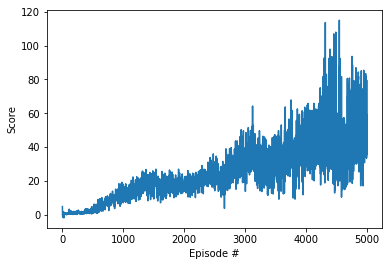

In [19]:
plotScores( crawler )

The crawler environment is not solved. But it shows and continous improvement over time and tuning the parameters to this environment could probably also make it resolve the environment. It may be nessecary to run it for additional episodes.



### 3. Conclusion

It is possible to create a deep reinforcement learning network that almost without changes can solve a number of different tasks. Though it dident solve all environments here it show a positive trend that with additional tuning of the hyper parameters most likely would be able to solve it.

The 20 agent version of the Reacher environment was solved in 107 episodes.


The adjustment of hyper parameters for the neural networks, replay buffers and noise generators is highly handcraft and luck. What seems to be intuitive has the complete opposite result. An example would be to increasing the replay buffer - and therefor having more old data in it. I would assume that it lowered the performance but to opposite happened.

The experiment to fill the replay buffer with succesful actions would also seem to be a way to improve leaning, but as can be taken from the first run this did not happen.




### 4. Future improvements

Futur improvements could be:
* Automation of hyper parameter finding. Ex: grid search.
* Futher fine tuning of the hyper parameters to solve all environments. 
* Try out other deep reinforcement learning algorithmes like PPO
* Investigate why the arm does not learn to find the goal by putting it up in place and wait for the goal to come and hit.


